### Run Bar Sampling

In [1]:
from FinancialMachineLearning.barsampling.core import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_parquet('../../Data/IVEfuture.parquet')

In [3]:
bar = RunBarFeatures(data)

#### 1. Tick Run Bar

Tick Imbalance Bar, Volume Imbalance Bar, Dollar value Imbalance Bar는 주문 흐름의 불균형을 틱, 거래량, 거래대금 가치 기준으로 모니터링한다. 대규모 거래자들은 order book을 전부 휩쓸어 가거나 Iceberg orders, 혹은 부모 주문을 다수의 자식 주문으로 쪼개는 방법 등으로 거래를 실행할 것인데, 이 모든 것은 시퀀스 $\{b_t\}_{t = 1, \dots, T}$안에 거래 흔적을 남긴다. 이러한 이유로 전체 거래량 안에서의 매수 시퀀스를 조사해 보는 것이 유용하며, 이 매수 시퀀스가 기대에서 벗어날 경우에 표본 추출을 한다.

첫째, 현재 런의 길이는 다음과 같이 정의할 수 있다.

$$\theta_T = \max \left\{
\sum_{t|b_t = 1}^T b_t, - \sum_{t|b_t = -1}^T b_t
\right\}$$

둘째, 바의 시작 시점에서의 기대값 $\theta_T$를 계산한다.

$$E_0[\theta_T] = E_0[T] \max \left\{
P[b_t = 1], 1 - P[b_t = 1]
\right\}$$

셋째, Tick Run Bar를 다음 조건을 만족하는 틱의 $T^*$ contigous 부분 집합으로 정의한다.

$$T^* = \arg \max_{T} \left\{ 
\theta_T \geq E_0[T] \max \left\{ 
P[b_t = 1], 1 - P[b_t = 1]
\right\}
\right\}$$

여기서 런의 기대 틱 횟수는 $\max \{P[b_t = 1], 1 - P[b_t = -1]\}$로 추정된다. $\theta_T$가 기대보다 더 많은 런을 보여준다면, 작은 $T$가 조건을 만족할 것이다. 런을 이렇게 정의하면 시퀀스 단절을 허용한다는 점에 주목하자. 즉, 가장 긴 시퀀스의 길이를 측정하는 대신, 다른 방향의 틱을 상계하지 않고, 각 방향의 틱 개수를 측정한다. 바를 형성하는 관점에서 이는 시퀀스 길이를 측정하는 것보다 더 유용한 정의다.

In [4]:
tick_run,_ = bar.const_tick_run_bar(expected_imbalance_window = 500, exp_num_ticks_init = 300)
tick_run

Reading data in batches:
Batch number: 0
Batch number: 1
Returning bars 



,date_time,tick_num,open,high,low,close,volume,cum_buy_volume,cum_ticks,cum_dollar_value
0,09/28/2009 10:33:32,713,50.7900,51.3800,50.7100,51.3400,219648,145523,713,1.124199e+07
1,09/28/2009 11:22:56,1002,51.3400,51.3700,51.2700,51.3500,71226,40593,289,3.655622e+06
2,09/28/2009 12:04:34,1260,51.3500,51.4400,51.3200,51.4400,108780,70210,258,5.589472e+06
3,09/28/2009 13:47:21,1648,51.4400,51.6000,51.4104,51.5700,85389,42315,388,4.395967e+06
4,09/28/2009 14:18:08,1984,51.5700,51.5700,51.4100,51.4400,104574,43145,336,5.380183e+06
...,...,...,...,...,...,...,...,...,...,...
38340,03/28/2024 14:11:56,11289784,186.7000,186.9100,186.5750,186.8950,45146,28589,246,8.432158e+06
38341,03/28/2024 14:44:01,11290059,186.8950,186.8950,186.6950,186.7001,46289,26743,275,8.647246e+06
38342,03/28/2024 15:22:26,11290363,186.7100,187.0400,186.7100,187.0250,108224,47568,304,2.022963e+07
38343,03/28/2024 15:50:12,11290732,187.0250,187.2399,186.9300,186.9500,64024,26923,369,1.197559e+07


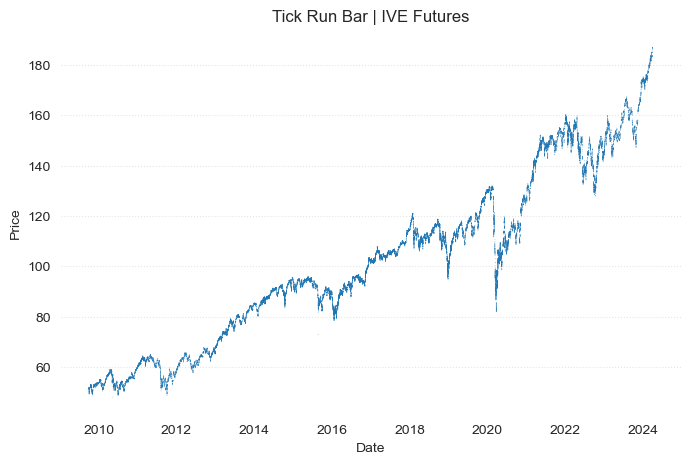

In [7]:
fig, ax = plt.subplots(figsize = (8, 5))
ax.scatter(
    pd.to_datetime(tick_run['date_time']), 
    tick_run.close,  
    s = 1, 
    marker = '.', 
    edgecolor = 'none',
    alpha = 0.75
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Tick Run Bar | IVE Futures')
plt.show()

#### 2. Volume Run Bar / Dollar Run Bar

Volume Run Bar나 Dollar Run Bar는 앞에서 언급한 각각 거래량 바와 거래대금 바를 Run Bar로 확장한 것이다. 이 직관은 거래량이나 거래대금의 특정 방향의 거래가 기대값을 초과한 경우에 표본 추출하는 것이다. 틱 규칙에 대한 관행적 명칭에 따라 바의 최종 관측값 index $T$를 결정할 필요가 있다.

첫째, Run에 연관된 거래량이나 거래대금은 다음과 같이 정의한다.

$$\theta_T = \max \left\{ 
\sum_{t|b_t = 1}^T b_t \nu_t, -\sum_{t |b_t = -1}^T b_t \nu_t
\right\}$$

여기서 $\nu_t$는 거래된 주식 수 또는 거래된 거래대금일 수 있다. $\nu_t$를 어떻게 정하냐에 따라서 전자나 후자 중 표본을 추출한다.

둘째, 바의 시작 시점에서 기대값 $\theta_T$를 계산한다.

$$E_0[\theta_T] = E_0[T]\max\{P[b_t = 1]E_0[\nu_t | b_t = 1], (1 - P[b_t = 1])E_0[\nu_t | b_t = -1]\}$$

사실 $E_0[T]$는 이전 바들로부터 $T$값의 지수 가중 이동 평균으로 계산할 수 있고, $P[b_t = 1]$는 이전 바들의 매수 틱 비율의 지수 가중 이동 평균으로 계산할 수 있다. 또한, $E_0[\nu_t | b_t = 1]$은 이전 바들의 매수 거래량 지수 가중 이동 평균으로, $E_0[\nu_t | b_t = -1]$ 이전 바들의 매도 거래량 지수 가중 이동 평균으로 추정할 수 있다.

셋째, Volume Run Bar를 다음 조건을 만족하는 틱의 $T^*$-contigous 부분 집합으로 정의한다.

$$T^* = \arg \min_T \left\{ 
\theta_T \geq E_0[T]\max\{P[b_t = 1]E_0[\nu_t | b_t = 1], (1 - P[b_t = 1])E_0[\nu_t | b_t = -1]\}
\right\}$$

여기서 Run의 기대 거래량은 $\max\{P[b_t = 1]E_0[\nu_t | b_t = 1], (1 - P[b_t = 1])E_0[\nu_t | b_t = -1]\}$로 추정된다. $\theta_T$가 기대값보다 많은 런을 보이거나 런으로부터의 거래량이 기대값보다 크다면 작은 $T$가 이 조건을 만족할 것이다.

In [6]:
volume_run, _ = bar.const_volume_run_bar(
    expected_imbalance_window = 300, 
    exp_num_ticks_init = 100
)
volume_run

Reading data in batches:
Batch number: 0
Batch number: 1
Returning bars 



,date_time,tick_num,open,high,low,close,volume,cum_buy_volume,cum_ticks,cum_dollar_value
0,09/28/2009 09:55:26,255,50.7900,51.1500,50.7100,51.1400,82595,58041,255,4.217550e+06
1,09/28/2009 10:02:52,372,51.1400,51.2600,51.0800,51.2600,36219,26854,117,1.854891e+06
2,09/28/2009 10:14:10,475,51.2590,51.2900,51.1900,51.2600,35914,26084,103,1.841100e+06
3,09/28/2009 10:30:22,649,51.2600,51.2900,51.1873,51.2900,50019,25195,174,2.563278e+06
4,09/28/2009 10:45:01,801,51.2900,51.3800,51.2800,51.3300,37863,19533,152,1.943896e+06
...,...,...,...,...,...,...,...,...,...,...
101827,03/28/2024 15:45:00,11290691,187.0450,187.0700,186.9600,187.0299,25059,10779,152,4.686867e+06
101828,03/28/2024 15:58:12,11290817,187.0300,187.0800,186.8700,187.0550,22092,9709,126,4.130996e+06
101829,03/28/2024 15:59:36,11290932,187.0600,187.1000,186.9700,187.0500,17159,5078,115,3.209520e+06
101830,03/28/2024 15:59:56,11291036,187.0300,187.0300,186.8200,186.8200,13699,3208,104,2.560193e+06


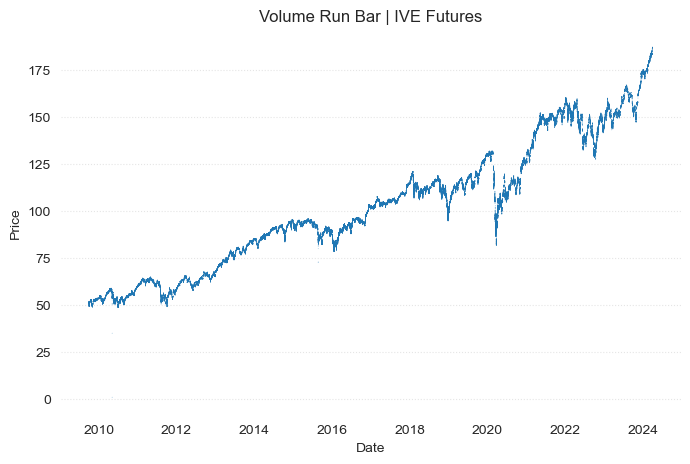

In [8]:
fig, ax = plt.subplots(figsize = (8, 5))
ax.scatter(
    pd.to_datetime(volume_run['date_time']), 
    volume_run.close,  
    s = 1, 
    marker = '.', 
    edgecolor = 'none',
    alpha = 0.75
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Volume Run Bar | IVE Futures')
plt.show()

#### 3. Dollar run bar

In [9]:
dollar_run,_ = bar.const_dollar_run_bar(
    expected_imbalance_window = 300, 
    exp_num_ticks_init = 100
)
dollar_run

Reading data in batches:
Batch number: 0
Batch number: 1
Returning bars 



,date_time,tick_num,open,high,low,close,volume,cum_buy_volume,cum_ticks,cum_dollar_value
0,09/28/2009 09:55:26,255,50.7900,51.1500,50.7100,51.1400,82595,58041,255,4.217550e+06
1,09/28/2009 10:02:52,372,51.1400,51.2600,51.0800,51.2600,36219,26854,117,1.854891e+06
2,09/28/2009 10:14:10,475,51.2590,51.2900,51.1900,51.2600,35914,26084,103,1.841100e+06
3,09/28/2009 10:30:22,649,51.2600,51.2900,51.1873,51.2900,50019,25195,174,2.563278e+06
4,09/28/2009 10:45:01,801,51.2900,51.3800,51.2800,51.3300,37863,19533,152,1.943896e+06
...,...,...,...,...,...,...,...,...,...,...
101763,03/28/2024 15:45:00,11290691,187.0450,187.0700,186.9600,187.0299,25059,10779,152,4.686867e+06
101764,03/28/2024 15:58:12,11290817,187.0300,187.0800,186.8700,187.0550,22092,9709,126,4.130996e+06
101765,03/28/2024 15:59:36,11290932,187.0600,187.1000,186.9700,187.0500,17159,5078,115,3.209520e+06
101766,03/28/2024 15:59:56,11291036,187.0300,187.0300,186.8200,186.8200,13699,3208,104,2.560193e+06


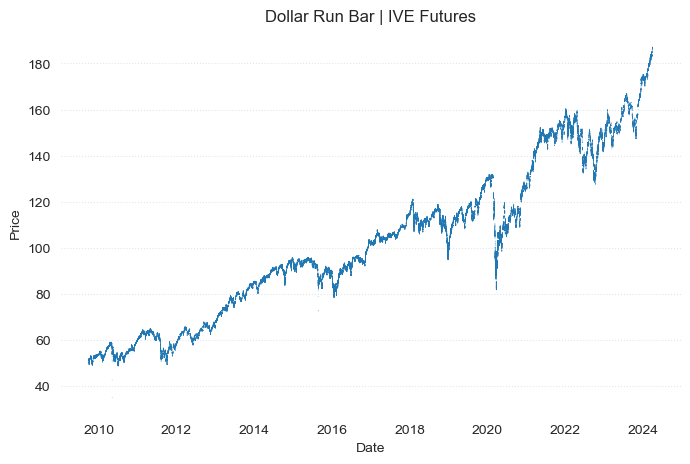

In [10]:
fig, ax = plt.subplots(figsize = (8, 5))
ax.scatter(
    pd.to_datetime(dollar_run['date_time']), 
    dollar_run.close,  
    s = 1, 
    marker = '.', 
    edgecolor = 'none',
    alpha = 0.75
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Dollar Run Bar | IVE Futures')
plt.show()

#### Memories

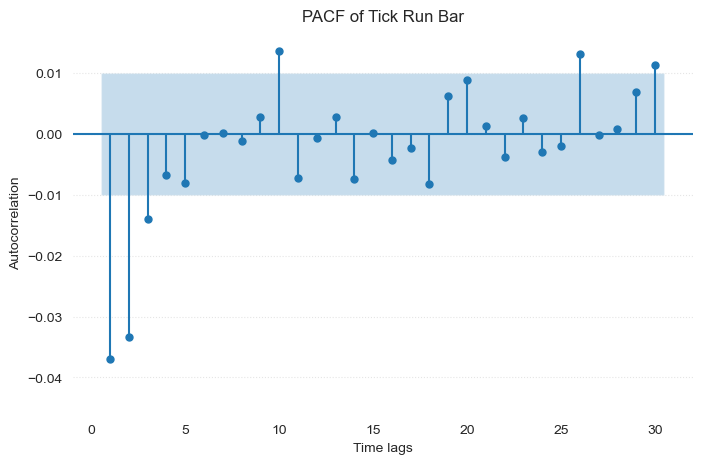

In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(figsize = (8, 5))
plot_pacf(
    tick_run['close'].pct_change().dropna(), 
    auto_ylims = True, 
    lags = range(1, 31),
    ax = ax
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.xlabel('Time lags')
plt.ylabel('Autocorrelation')
plt.title('PACF of Tick Run Bar')
plt.show()

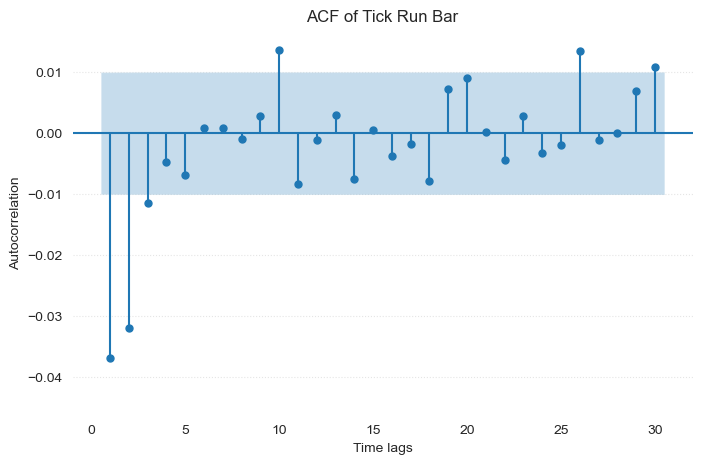

In [14]:
fig, ax = plt.subplots(figsize = (8, 5))
plot_acf(
    tick_run['close'].pct_change().dropna(), 
    auto_ylims = True, 
    lags = range(1, 31),
    ax = ax
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.xlabel('Time lags')
plt.ylabel('Autocorrelation')
plt.title('ACF of Tick Run Bar')
plt.show()

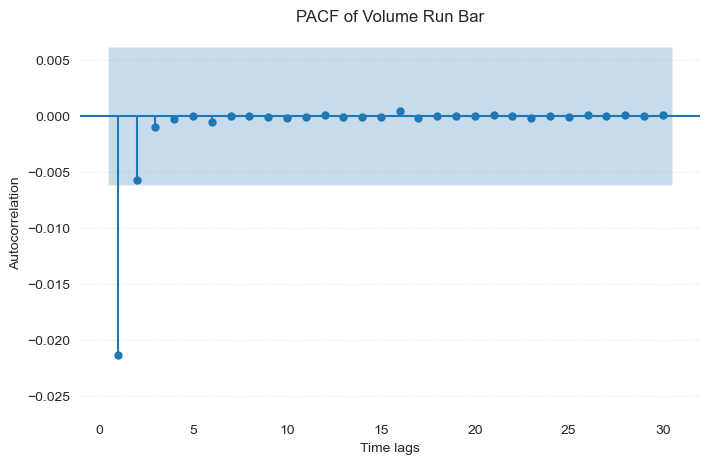

In [16]:
fig, ax = plt.subplots(figsize = (8, 5))
plot_pacf(
    volume_run['close'].pct_change().dropna(), 
    auto_ylims = True, 
    lags = range(1, 31),
    ax = ax
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.xlabel('Time lags')
plt.ylabel('Autocorrelation')
plt.title('PACF of Volume Run Bar')
plt.show()

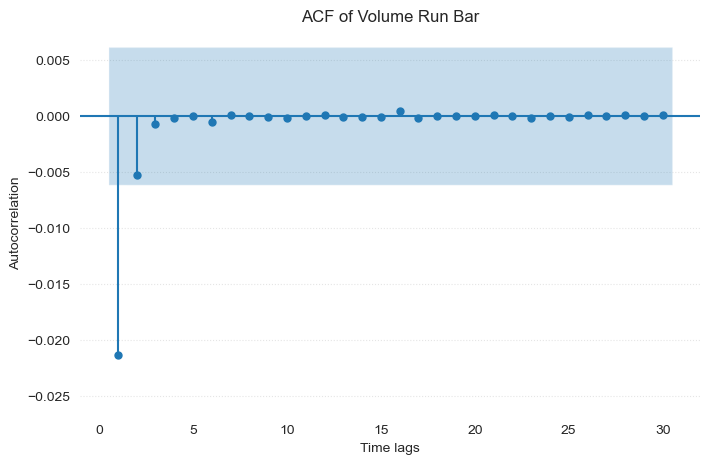

In [15]:
fig, ax = plt.subplots(figsize = (8, 5))
plot_acf(
    volume_run['close'].pct_change().dropna(), 
    auto_ylims = True, 
    lags = range(1, 31),
    ax = ax
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.xlabel('Time lags')
plt.ylabel('Autocorrelation')
plt.title('ACF of Volume Run Bar')
plt.show()

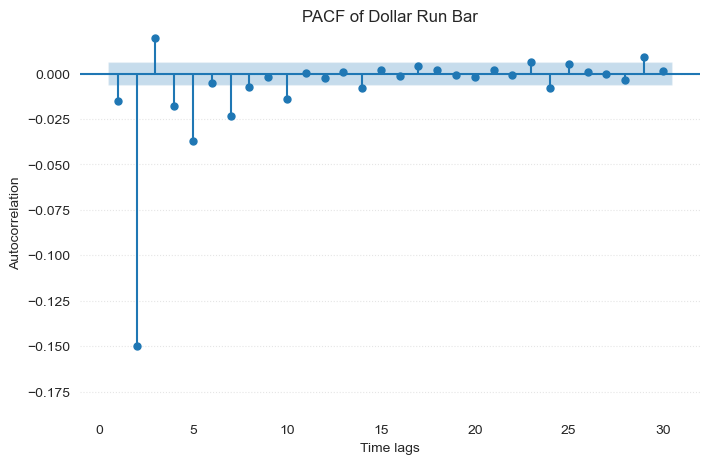

In [17]:
fig, ax = plt.subplots(figsize = (8, 5))
plot_pacf(
    dollar_run['close'].pct_change().dropna(), 
    auto_ylims = True, 
    lags = range(1, 31),
    ax = ax
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.xlabel('Time lags')
plt.ylabel('Autocorrelation')
plt.title('PACF of Dollar Run Bar')
plt.show()

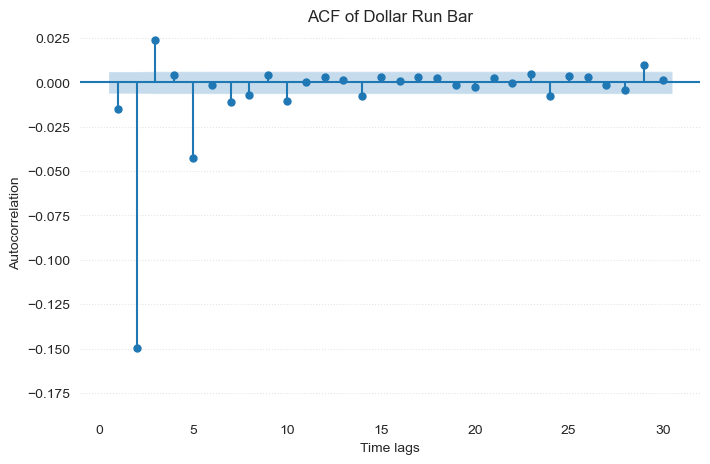

In [18]:
fig, ax = plt.subplots(figsize = (8, 5))
plot_acf(
    dollar_run['close'].pct_change().dropna(), 
    auto_ylims = True, 
    lags = range(1, 31),
    ax = ax
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.xlabel('Time lags')
plt.ylabel('Autocorrelation')
plt.title('ACF of Dollar Run Bar')
plt.show()